# __<u>Initialize Cloud-AI Engine</u>__ 
> with a developed and distinct environment: __py39==ens3 (Python 3.9.16)__
>> you can use --> cmd Run: __conda install -n py39==ens3 ipykernel --update-deps --force-reinstall__

> Install/Verify Packages

In [4]:
# %pip install --user --upgrade pandas
# %pip install --user --upgrade "sqlalchemy<2.0"
# %pip install --user --upgrade mariadb
# %pip install --user --upgrade -U matplotlib
# %pip install --user --upgrade seaborn
# %pip install --user -U scikit-learn

> Import Libraries

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.layers import Dense
import gym
from collections import deque
import seaborn as sns
import random

# __Configure Simulation Setup__

> Define directory of Processed Data

In [6]:
loadDirectory = '../Data/ProcessedData/'

>Define directory of Trained Models

In [7]:
# Create a directory to save the models
model_save_dir = "saved_models_v7.7"
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

> Define colunmns and rows of pandas output

In [8]:
# pd.set_option('display.max_columns', 50)
# pd.set_option('display.max_rows', 50000)

> Work on GPU utilization
>> 1. https://www.tensorflow.org/guide/gpu#limiting_gpu_memory_growth
>> 2. https://www.tensorflow.org/guide/gpu#using_multiple_gpus
>> 3. https://www.tensorflow.org/guide/gpu#using_a_single_gpu_on_a_multi-gpu_system

In [9]:
### Limiting GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
print('Available Physical GPUs=>'+str(gpus))
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print('Configured Logical GPUs=>'+str(logical_gpus))
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Available Physical GPUs=>[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Configured Logical GPUs=>[LogicalDevice(name='/device:GPU:0', device_type='GPU'), LogicalDevice(name='/device:GPU:1', device_type='GPU')]


> Define GPU which will be used

In [10]:
# Set the GPU you want to use
selectGPU = 0
os.environ["CUDA_VISIBLE_DEVICES"] = str(selectGPU)
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if len(physical_devices) > 0:
    selectedGPU = f"/device:GPU:{selectGPU}"
    print(f"Using GPU: {selectedGPU}")

### Clearing Tensorflow Session
tf.keras.backend.clear_session()

Using GPU: /device:GPU:0


# __<u>PV Data Processing for Model Development and Testing</u>__

> __<u> Load Pre-processed Power Plants data for each PV power plant </u>__
>> Note from ENS: 
>>   * Power_Plant 3, C_pcode __71780001~71780003__ : Seomyeon, Gyeongju-si, Gyeongsangbuk-do

In [11]:
PV1 = pd.read_csv(f"{loadDirectory}PV_71780001.gzip", compression="gzip")
PV2 = pd.read_csv(f"{loadDirectory}PV_71780002.gzip", compression="gzip") 
PV3 = pd.read_csv(f"{loadDirectory}PV_71780004.gzip", compression="gzip")

> <b>Dropped</b> unnecessary data, <b>renamed</b> column and <b>set index</b> with timestamp

In [12]:
PV1 = PV1.drop(columns={'day_power'}).rename(columns={'inst_power':'pv1_power'}).set_index('timestamp')
PV2 = PV2.drop(columns={'day_power'}).rename(columns={'inst_power':'pv2_power'}).set_index('timestamp')
PV3 = PV3.drop(columns={'day_power'}).rename(columns={'inst_power':'pv3_power'}).set_index('timestamp')

>Combine above dataFrames to <b>raw_data</b> according to the index and <b>calculated total power</b>

In [13]:
raw_data = PV1.join(PV2).join(PV3)
raw_data = raw_data.fillna(0)
# calculate the total power output and add it as a new column
raw_data['total_power'] = raw_data.sum(axis=1)
raw_data=raw_data.reset_index()
# Convert the 'timestamp' column to a pandas datetime object
raw_data['timestamp'] = pd.to_datetime(raw_data['timestamp'])
raw_data ['timestamp'][0]

Timestamp('2020-11-10 18:20:00')

In [14]:
def calculate_hourly_data(data):
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    data.set_index('timestamp', inplace=True)
    hourly_data = data.resample('H').sum()
    hourly_data=hourly_data.reset_index()
    hourly_data['timestamp'] = pd.to_datetime(hourly_data['timestamp'])
    hourly_data.fillna(0, inplace=True) # Fill null values with zero
    return hourly_data

In [15]:
raw_data

,timestamp,pv1_power,pv2_power,pv3_power,total_power
0,2020-11-10 18:20:00,0.0,0.0,0.0,0.0
1,2020-11-10 18:21:00,0.0,0.0,0.0,0.0
2,2020-11-10 18:22:00,0.0,0.0,0.0,0.0
3,2020-11-10 18:23:00,0.0,0.0,0.0,0.0
4,2020-11-10 18:24:00,0.0,0.0,0.0,0.0
...,...,...,...,...,...
1205491,2023-03-16 08:57:00,47.4,35.1,24.3,106.8
1205492,2023-03-16 08:58:00,51.7,40.6,27.0,119.3
1205493,2023-03-16 08:59:00,44.3,48.6,32.6,125.5
1205494,2023-03-16 09:00:00,50.8,54.0,28.0,132.8


In [16]:
hourly_data = calculate_hourly_data(raw_data)
hourly_data

,timestamp,pv1_power,pv2_power,pv3_power,total_power
0,2020-11-10 18:00:00,0.0,0.0,0.0,0.0
1,2020-11-10 19:00:00,0.0,0.0,0.0,0.0
2,2020-11-10 20:00:00,0.0,0.0,0.0,0.0
3,2020-11-10 21:00:00,0.0,0.0,0.0,0.0
4,2020-11-10 22:00:00,0.0,0.0,0.0,0.0
...,...,...,...,...,...
20531,2023-03-16 05:00:00,0.0,0.0,0.0,0.0
20532,2023-03-16 06:00:00,45.0,40.9,21.8,107.7
20533,2023-03-16 07:00:00,437.1,416.3,357.2,1210.6
20534,2023-03-16 08:00:00,1287.9,1213.1,1035.1,3536.1


In [17]:
hourly_data.describe()

,pv1_power,pv2_power,pv3_power,total_power
count,20536.000000,20536.000000,20536.000000,20536.000000
mean,802.018192,838.547478,970.139029,2610.704699
std,1300.019254,1382.067278,1516.458878,4153.779691
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,7.900000,3.200000,6.650000,23.400000
75%,1181.925000,1130.125000,1495.525000,3852.475000
max,5707.700000,5802.900000,5865.400000,17200.100000


In [18]:
hourly_data['timestamp'][0]

Timestamp('2020-11-10 18:00:00')

>Plot each column of <b>plot_data</b> against the timestamp

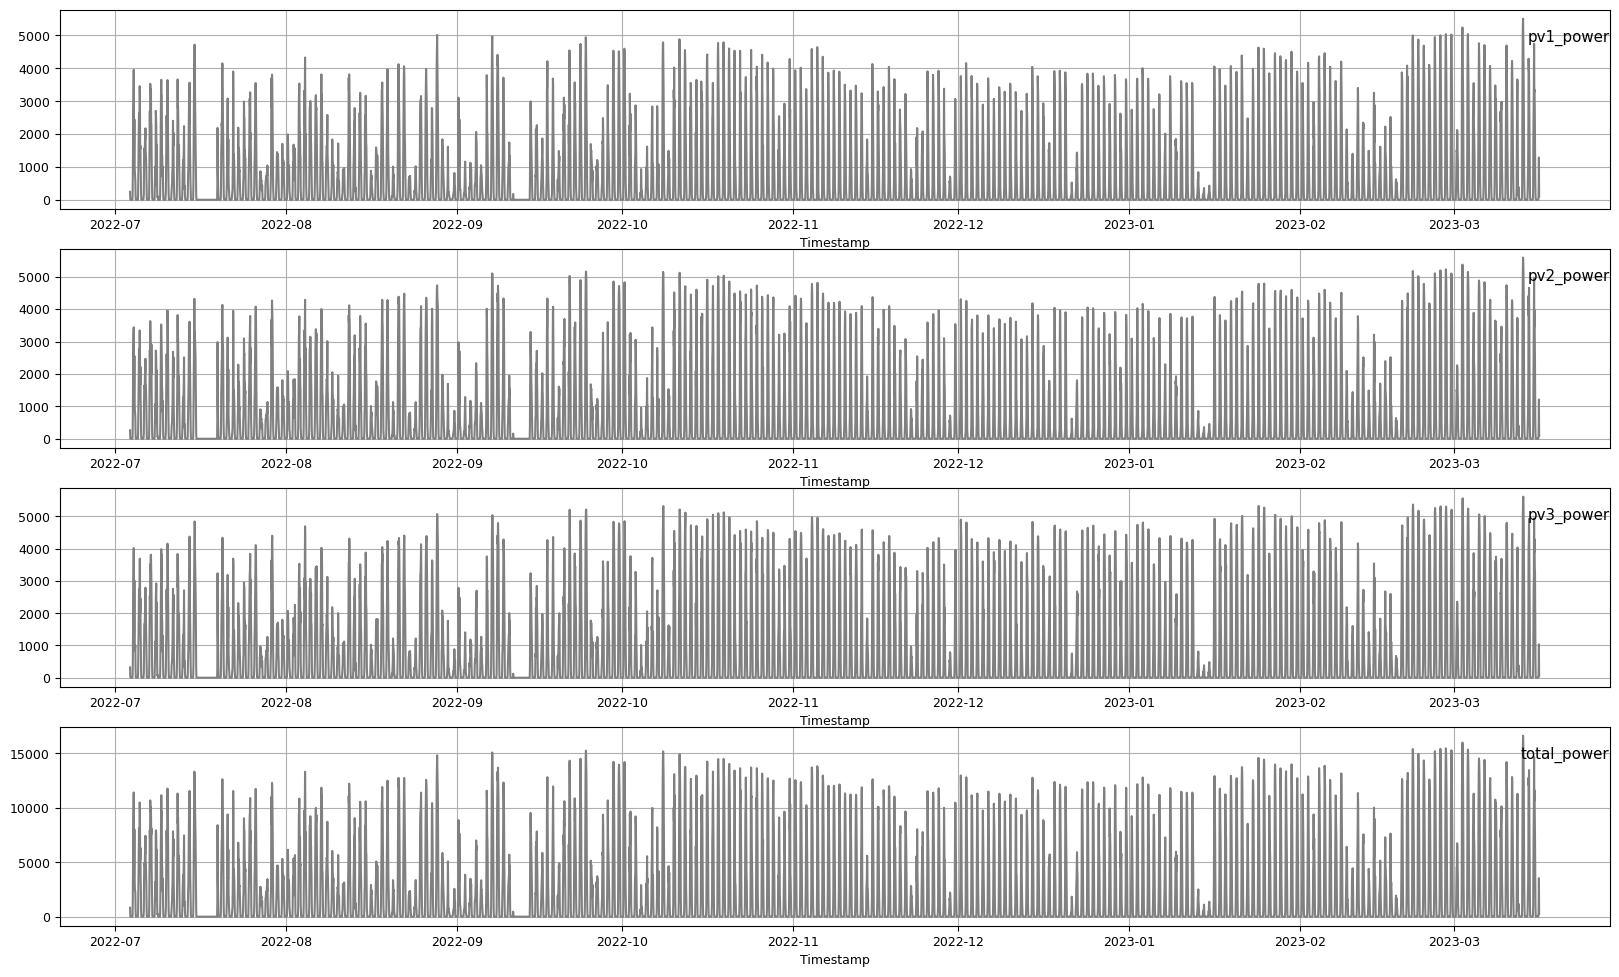

In [19]:
# plot_data = raw_data[60*24*15:]
# plot_data = raw_data[60*24*30*20:]
plot_data = hourly_data[24*30*20:]
i    = 1
plt.figure(figsize=(20, 15))
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['font.size'] = '9'
for counter in range(1,len(plot_data.columns)):
    plt.subplot(len(plot_data.columns), 1, i)
    plt.plot(plot_data.values[:, 0], plot_data.values[:, counter], color = 'gray')
    # plt.plot(plot_data.values[:, counter], color = 'gray')
    plt.title(plot_data.columns[counter], y=0.8, loc='right')
    plt.xlabel('Timestamp')
    plt.ylabel('')
    plt.grid(True)
    i = i+1
plt.show()

In [20]:
plot_data

,timestamp,pv1_power,pv2_power,pv3_power,total_power
14400,2022-07-03 18:00:00,241.7,260.0,318.1,819.8
14401,2022-07-03 19:00:00,23.8,16.5,34.0,74.3
14402,2022-07-03 20:00:00,0.0,0.0,0.0,0.0
14403,2022-07-03 21:00:00,0.0,0.0,0.0,0.0
14404,2022-07-03 22:00:00,0.0,0.0,0.0,0.0
...,...,...,...,...,...
20531,2023-03-16 05:00:00,0.0,0.0,0.0,0.0
20532,2023-03-16 06:00:00,45.0,40.9,21.8,107.7
20533,2023-03-16 07:00:00,437.1,416.3,357.2,1210.6
20534,2023-03-16 08:00:00,1287.9,1213.1,1035.1,3536.1


> <b>Segment data</b> into windows of specified length and stride

In [21]:
# input features
data = plot_data.drop(columns=['timestamp'])
# Convert plot_data to data_np as np array
data_np = np.array(data)
# Replacing 0 with 0.01
# data_np[data_np == 0] = 0.01
print(data_np)

# Define window length and stride for segmenting data
window_length  = 24*30   # Length of the window (number of data points per segment)
stride         = 24*13    # Number of data points to move the window after each episode
train_percent  = 0.95      # 95%
# Assuming pv1_power, pv2_power, and pv3_power are the column indices for the respective columns
pv1_power	 = 0
pv2_power	 = 1
pv3_power	 = 2
net_power    = 3  

# Initialize an empty list to store the segmented data
data_index       = 0
data_np_segments = []
for episode_start in range(0, len(data_np), stride):
    episode_end = episode_start + window_length
    print(f'data_index={data_index} | episode_start={episode_start} | episode_end={episode_end}\x00')
    # Slice the train_data array to get the specified columns for the current segment
    data_segment = data_np[episode_start:episode_end, [pv1_power, pv2_power, pv3_power, net_power]]
    # Append the segment to the list
    data_np_segments.append(data_segment)
    data_index += 1

num_total_episodes = data_index-1
num_train_episodes = int(num_total_episodes*train_percent)
num_test_episodes  = num_total_episodes-num_train_episodes

print(f'\nnum_train_episodes={num_train_episodes} | num_test_episodes={num_test_episodes}\x00')

[[ 241.7  260.   318.1  819.8]
 [  23.8   16.5   34.    74.3]
 [   0.     0.     0.     0. ]
 ...
 [ 437.1  416.3  357.2 1210.6]
 [1287.9 1213.1 1035.1 3536.1]
 [ 103.9  100.7   56.3  260.9]]
data_index=0 | episode_start=0 | episode_end=720 
data_index=1 | episode_start=312 | episode_end=1032 
data_index=2 | episode_start=624 | episode_end=1344 
data_index=3 | episode_start=936 | episode_end=1656 
data_index=4 | episode_start=1248 | episode_end=1968 
data_index=5 | episode_start=1560 | episode_end=2280 
data_index=6 | episode_start=1872 | episode_end=2592 
data_index=7 | episode_start=2184 | episode_end=2904 
data_index=8 | episode_start=2496 | episode_end=3216 
data_index=9 | episode_start=2808 | episode_end=3528 
data_index=10 | episode_start=3120 | episode_end=3840 
data_index=11 | episode_start=3432 | episode_end=4152 
data_index=12 | episode_start=3744 | episode_end=4464 
data_index=13 | episode_start=4056 | episode_end=4776 
data_index=14 | episode_start=4368 | episode_end=5088 


> Test_point

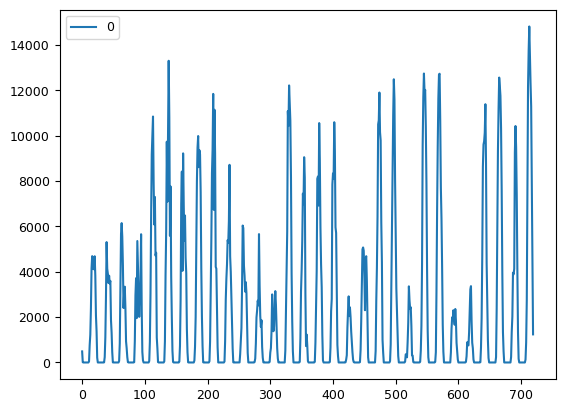

In [22]:
# print(data_np_segments[1])
pd.DataFrame(data_np_segments[2][:,3]).plot()
plt.show()

# __<u>DDPG-based Stochastic Optimal Power Flow Analysis of VPP</u>__

> Max Capacity of each PV sources is 100kW
- If the energy storage system (ESS) has a capacity of 200 kWh and is currently at 0 kWh, we can calculate the time required to fully charge the ESS using a 100 kW solar panel system that is generating 80 kW instantaneously.
- To do this, we also need to consider the charging efficiency of the ESS. Assuming the charging efficiency is 95% (0.95), the effective charging power will be:
- Effective charging power = Instantaneous solar power * Charging efficiency
- Now, let's calculate the effective charging power:
- Effective charging power = 80 kW * 0.95 = 76 kW
- The time required to fully charge the ESS can be found by dividing the ESS capacity by the effective charging power:
- Charging time = ESS capacity / Effective charging power
- Charging time = 200 kWh / 76 kW ≈ 2.63 hours
- It will take approximately 2.63 hours to fully charge the ESS from 0 kWh to 200 kWh using a 100 kW solar panel system generating 80 kW instantaneously, considering a charging efficiency of 95%.
- Now, we need to convert the effective charging power to energy (kWh) for a 1-minute duration. Since there are 60 minutes in an hour, we can calculate the energy generated in 1 minute as follows:
- Energy generated in 1 minute = Effective charging power * (1 minute / 60 minutes)
- Energy generated in 1 minute = 76 kW * (1/60) ≈ 1.267 kWh

In [23]:
class DDPG:
    def __init__(self, state_dim, action_dim, lr_actor, lr_critic, gamma, tau):
        self.state_dim        = state_dim
        self.action_dim       = action_dim
        self.lr_actor         = lr_actor
        self.lr_critic        = lr_critic
        self.gamma            = gamma
        self.tau              = tau
        self.actor            = self.build_actor()
        self.target_actor     = self.build_actor()
        self.critic           = self.build_critic()
        self.target_critic    = self.build_critic()
        self.actor_optimizer  = tf.keras.optimizers.Adam(lr_actor)
        self.critic_optimizer = tf.keras.optimizers.Adam(lr_critic)

    def build_actor(self):
        model = tf.keras.Sequential([
            Dense(128, activation='relu', input_shape=(self.state_dim,)),
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(self.action_dim, activation='tanh')
        ])
        return model
    
    def build_critic(self):
        state_input  = tf.keras.Input(shape=(self.state_dim,))
        action_input = tf.keras.Input(shape=(self.action_dim,))
        state_net    = Dense(128, activation='relu')(state_input)
        state_net    = Dense(64, activation='relu')(state_net)
        action_net   = Dense(64, activation='relu')(action_input)
        net          = tf.keras.layers.Concatenate()([state_net, action_net])
        net          = Dense(64, activation='relu')(net)
        net          = Dense(32, activation='relu')(net)
        net          = Dense(1)(net)
        model        = tf.keras.Model(inputs=[state_input, action_input], outputs=net)
        return model
    
    def update_target_networks(self):
        actor_weights         = self.actor.get_weights()
        target_actor_weights  = self.target_actor.get_weights()
        critic_weights        = self.critic.get_weights()
        target_critic_weights = self.target_critic.get_weights()
        for i in range(len(actor_weights)):
            target_actor_weights[i]  = self.tau * actor_weights[i]  + (1 - self.tau) * target_actor_weights[i]
        for i in range(len(critic_weights)):
            target_critic_weights[i] = self.tau * critic_weights[i] + (1 - self.tau) * target_critic_weights[i]
        self.target_actor.set_weights(target_actor_weights)
        self.target_critic.set_weights(target_critic_weights)

    def train(self, replay_buffer, batch_size):
        with tf.device(selectedGPU):  # Adding this line to ensure operations are performed on the specified GPU
            states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
            # Update critic
            target_actions = self.target_actor(next_states)
            target_q_values = self.target_critic([next_states, target_actions])
            target_q_values = tf.stop_gradient(rewards + (1 - dones) * self.gamma * target_q_values)
            with tf.GradientTape() as tape:
                q_values = self.critic([states, actions])
                critic_loss = tf.reduce_mean(tf.square(target_q_values - q_values))
            critic_grad = tape.gradient(critic_loss, self.critic.trainable_variables)
            self.critic_optimizer.apply_gradients(zip(critic_grad, self.critic.trainable_variables))
            # Update actor
            with tf.GradientTape() as tape:
                actions = self.actor(states)
                actor_loss = -tf.reduce_mean(self.critic([states, actions]))
            actor_grad = tape.gradient(actor_loss, self.actor.trainable_variables)
            self.actor_optimizer.apply_gradients(zip(actor_grad, self.actor.trainable_variables))
            # Update target networks
            self.update_target_networks()

    def load_weights(self, actor_weights_path, critic_weights_path):
        self.actor.load_weights(actor_weights_path)
        self.critic.load_weights(critic_weights_path)


class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)

    def store(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        try:
            return [np.array(x) for x in zip(*batch)]
        except ValueError as e:
            print("Error: ", e)
            print("Samples causing the issue:")
            for sample in batch:
                print(sample)
            raise

    def __len__(self):
        return len(self.buffer)
    


class VPPEnvironment(gym.Env):
    def __init__(self, power_data):
        super(VPPEnvironment, self).__init__()
        self.demand_min                = 1000 # 1MW
        self.demand_max                = 5000 # 5MW
        self.demand_uncertainty_factor = 0.001
        self.ess_max                   = 2000 #20x100kWH ESS Battery
        self.charging_efficiency       = 0.85
        self.discharging_efficiency    = 0.95
        self.duration_of_operation     = 1/60
        self.action_dim                = 3
        self.state_dim                 = 4
        self.power_data                = power_data
        self.current_step              = 0
        self.ess                       = 0
        self.demand_deviation          = 0
        self.power                     = 0
        self.demand                    = 0
        self.action_space              = gym.spaces.Box(low=-1, high=1, shape=(self.action_dim,), dtype=np.float32)
        self.observation_space         = gym.spaces.Box(low= 0, high=1, shape=(self.state_dim,),  dtype=np.float32)
        self.power_max                 = np.max(self.power_data)

    def reset(self):
        self.current_step              = 0
        self.demand_deviation          = 0
        self.ess                       = 0
        action_level                   = 0
        return self._get_observation(action_level)

    def get_demand(self, current_power):
        demand_range                   = self.demand_max - self.demand_min
        demand                         = self.demand_min + (self.power_max  - current_power) / self.power_max * demand_range
        uncertainty                    = np.random.normal(0, self.demand_uncertainty_factor * demand_range)
        return np.clip(demand + uncertainty, self.demand_min, self.demand_max)

    def _get_observation(self, action_deg):
        scaled_power                   = round(self.power/self.power_max, 4)
        scaled_demand                  = round(self.demand/self.demand_max, 4)
        scaled_battery                 = round(self.ess/ self.ess_max, 4)
        scaled_demand_deviation        = round(self.demand_deviation/self.demand_max, 4)      
        scaled_state_values            = np.array([action_deg, scaled_power, scaled_demand, scaled_battery])
        # scaled_state_values            = np.array([scaled_demand_deviation])
        # print(f'scaled_state_values={scaled_state_values}')
        return scaled_state_values

    def step(self, action):
        clipped_action                 = np.clip(action, self.action_space.low, self.action_space.high)
        self.power                     = self.power_data[self.current_step] # + self.ess # Power from PV and ESS
        self.demand                    = self.get_demand(self.power) # Generating Demand
        reward                         = 0
        charging_count                 = 0
        discharging_count              = 0
        action_type                    = 'System Started'

        # Agent's actions
        # ESS should be charged until it is full during extra power generation
        if clipped_action[0] > clipped_action[1] and clipped_action[0] > clipped_action[2]:
            discharge_amount           = 0
            if self.power > self.demand and self.ess < self.ess_max * self.charging_efficiency:
                action_type            = "Charging[OK]"
                charge_amount          = min((self.power - self.demand) * self.charging_efficiency, self.ess_max * self.charging_efficiency - self.ess)
                self.ess              += charge_amount
                reward                += 2
                charging_count        += 1
            else:
                action_type            = "Charging[NA]"
                reward                -= 1
                charge_amount          = 0
        # ESS should be discharged unless it is almost empty during less power generation
        elif clipped_action[1] > clipped_action[0] and clipped_action[1] > clipped_action[2]:
            charge_amount              = 0
            if self.power < self.demand and self.ess > 1* self.discharging_efficiency:
                action_type            = "Discharging[OK]"
                discharge_amount       = max(self.ess, 1)* self.discharging_efficiency
                self.ess              -= discharge_amount
                reward                += 2
                discharging_count     += 1
            else:
                action_type            = "Discharging[NA]"
                reward                -= 1
                discharge_amount       = 0
        # ESS should be isolated when it is full and power generation meets demand
        elif clipped_action[2] > clipped_action[0] and clipped_action[2] > clipped_action[1]:
            action_type                = "Isolated"
            charge_amount              = 0
            discharge_amount           = 0
            if self.power > self.demand and self.ess >= self.ess_max:
                reward                += 1
            else:
                reward                -= 2
        
        # Demand deviation should be minimized gradually
        self.demand_deviation          = abs(self.power + self.ess - self.demand)
        # reward                        -= self.demand_deviation
        reward                        -= 3 if self.demand_deviation > 0 else reward
        
        self.current_step             += 1
        
        done = self.current_step >= len(self.power_data) - 1

        # Create a dictionary to map action_type values to new action_level variables
        action_map = {
            "Isolated": 0,
            "Discharging[N/A]": 0.25,
            "Charging[N/A]": 0.5,
            "Discharging[OK]": 0.75,
            "Charging[OK]": 1
        }
        # Get the value for the new variable based on action_type
        action_level = action_map.get(action_type, 0)  # Default value is 0 if action_type is not in the dictionary


        info = {
            'current_step'           : self.current_step, 
            'current_pv_power'       : self.power, 
            'current_demand'         : self.demand,
            'current_action'         : action_type, 
            'current_ess'            : self.ess,
            'demand_deviation'       : self.demand_deviation,
            'charging_count'         : charging_count,
            'discharging_count'      : discharging_count,
            'action_value'           : clipped_action
        }
        return self._get_observation(action_level), reward, done, info

In [24]:
def plot_rewards_and_deviations(episode_rewards, demand_deviations, saving_name, model_save_dir=model_save_dir):
    episodes = range(1, len(episode_rewards) + 1)
    # Set a style and color palette
    sns.set(style="whitegrid")
    color_palette = sns.color_palette("deep")
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(episodes, episode_rewards, linestyle='-', linewidth=2, marker='o', markersize=3, color=color_palette[0], markerfacecolor='w', markeredgewidth=1.5)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward")
    plt.title("Episode Rewards")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.subplot(2, 1, 2)
    plt.plot(episodes, demand_deviations, linestyle='-', linewidth=2, marker='s', markersize=3, color=color_palette[2], markerfacecolor='w', markeredgewidth=1.5)
    plt.xlabel("Episode")
    plt.ylabel("Demand Deviation")
    plt.title("Episode Demand Deviations")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    # Save the plot as a file
    plot_path = os.path.join(model_save_dir, saving_name+'.png')
    plt.savefig(plot_path)
    # Show the plot
    plt.show()

def evaluate_saved_models(model_save_dir, num_train_episodes, num_test_episodes, max_steps_per_episode):
    model_files = os.listdir(model_save_dir)
    def custom_sort(file_name):
        episode_number = int(file_name.split('_')[2].split('.')[0])
        return episode_number

    sorted_actor_files = sorted([file for file in model_files if 'actor' in file], key=custom_sort)
    sorted_critic_files = sorted([file for file in model_files if 'critic' in file], key=custom_sort)

    paired_files = list(zip(sorted_actor_files, sorted_critic_files))

    # Assuming the column names are 'pv1_power', 'pv2_power', and 'pv3_power'
    column_names = ['pv1_power', 'pv2_power', 'pv3_power']
    # Convert the NumPy array in train_data_np_segments to a pandas DataFrame
    test_segment = pd.DataFrame(data_np_segments[num_train_episodes+1], columns=column_names)
    # Create Test Environment
    env   = VPPEnvironment(test_segment)
    # Evaluate the saved models
    agent = DDPG(state_dim=env.state_dim, action_dim=env.action_dim, lr_actor=0.001, lr_critic=0.002, gamma=0.99, tau=0.005)

    test_episode_rewards = []
    test_episode_deviations = []

    for actor_model_file, critic_model_file in paired_files:
        actor_weights_path = os.path.join(model_save_dir, actor_model_file)
        critic_weights_path = os.path.join(model_save_dir, critic_model_file)
        agent.load_weights(actor_weights_path, critic_weights_path)

        total_reward = []
        total_deviation = []
        
        for test_episode in range(num_train_episodes+1, num_train_episodes+num_test_episodes, 1):

            test_segment    = pd.DataFrame(data_np_segments[test_episode], columns=column_names)
            env             = VPPEnvironment(test_segment)

            state              = env.reset()
            episode_reward     = 0
            episode_deviation  = []
            done               = False
            step_counter       = 0

            while not done:
                step_counter += 1
                action = agent.actor(np.expand_dims(state, axis=0)).numpy()[0]
                next_state, reward, done, info = env.step(action)

                state = next_state
                episode_reward += reward
                episode_deviation.append(info['demand_deviation'])
                
                if step_counter >= max_steps_per_episode:
                    break
                
                print(f"Episode={test_episode+1} | Count_Steps={info['current_step']} | Demand_Deviation={np.mean(episode_deviation):.2f} | Accumulated_Rewards={episode_reward:.2f} \x00", end='\r')

            total_reward.append(episode_reward)
            total_deviation.append(episode_deviation)

        avg_reward             = np.mean(total_reward)
        avg_deviation          = np.mean(total_deviation)
        test_episode_rewards.append(avg_reward)
        test_episode_deviations.append(avg_deviation)

        print(f"Model {actor_model_file} and {critic_model_file}: Average Reward = {avg_reward:.2f} | Average Demand Gap = {avg_deviation:.2f}\x00")

    # Plot the evaluation results
    plot_rewards_and_deviations(test_episode_rewards, test_episode_deviations, 'evaluating_trained_models')

In [25]:
def main():
    with tf.device(selectedGPU):  # Add this line to ensure operations are performed on the specified GPU
        # Initialize Parameters
        num_saving_models = 10
        batch_size        = 1
        warm_up           = 1000
        train_episodes    = num_train_episodes
        max_steps         = window_length
        saving_interval   = int(num_train_episodes/num_saving_models)
        total_steps       = 0
        episode_rewards   = []
        demand_deviations = []
        train_segment     = data_np_segments[0][:,3]
        
        # Initialize DDPG System
        env               = VPPEnvironment(train_segment)
        agent             = DDPG(state_dim=env.state_dim, action_dim=env.action_dim, lr_actor=0.001, lr_critic=0.002, gamma=0.99, tau=0.005)
        replay_buffer     = ReplayBuffer(max_size=100000)
        
        # Training Loop per Episode
        for episode in range(train_episodes):
            train_segment             = data_np_segments[episode][:,3]
            env                       = VPPEnvironment(train_segment)
            state                     = env.reset()
            episode_reward            = 0
            cumulative_deviation      = 0
            charging_count            = 0
            discharging_count         = 0

            # Training Loop per Episode
            for step in range(max_steps):
                action = agent.actor(np.expand_dims(state, axis=0)).numpy()[0]
                next_state, reward, done, info = env.step(action)
                replay_buffer.store(state, action, float(reward), next_state, done)

                state                 = next_state
                episode_reward       += reward
                current_step          = info['current_step']
                current_pv_power      = info['current_pv_power']
                current_demand        = info['current_demand']
                current_action        = info['current_action']
                current_ess           = info['current_ess']
                cumulative_deviation += info['demand_deviation']
                charging_count       += info['charging_count']
                discharging_count    += info['discharging_count']
                action_value          = info['action_value']
                total_steps          += 1
                
                print(f'Episode={episode+1} << Step={current_step} | ESS_Action={current_action} | A={action_value} | C={charging_count} | D={discharging_count} | ESS_Value={current_ess:.2f} | PV_Power={current_pv_power:.2f} | Demand={current_demand:.2f} | Demand_Gap={cumulative_deviation/current_step:.2f} | Cumulative_Rewards={episode_reward:.2f} \x00', end='\r')
   
                if total_steps > warm_up and len(replay_buffer) >= batch_size:
                    agent.train(replay_buffer, batch_size)

                if done:
                    break
           
            episode_rewards.append(episode_reward)
            demand_deviations.append(cumulative_deviation/current_step)

            print(f'Episode={episode+1} << Step={current_step} | ESS_Action={current_action} | A={action_value} | C={charging_count} | D={discharging_count} | ESS_Value={current_ess:.2f} | PV_Power={current_pv_power:.2f} | Demand={current_demand:.2f} | Demand_Gap={cumulative_deviation/current_step:.2f} | Cumulative_Rewards={episode_reward:.2f} \x00')

            if (episode+1) % saving_interval == 0 or (episode+1 == train_episodes):
                actor_save_path  = os.path.join(model_save_dir,  f"actor_episode_{episode + 1}.h5")
                critic_save_path = os.path.join(model_save_dir, f"critic_episode_{episode + 1}.h5")
                agent.actor.save_weights(actor_save_path)
                agent.critic.save_weights(critic_save_path)
                print(f"Actor model saved in {actor_save_path}")
                print(f"Critic model saved in {critic_save_path}")

        # Return episode_rewards and demand_deviations
        return episode_rewards, demand_deviations

In [26]:
if __name__ == '__main__':
    rewards, deviations = main()

Episode=1 << Step=719 | ESS_Action=Isolated | A=[-0.07033607 -0.04182984  0.07075726] | C=1 | D=0 | ESS_Value=1700.00 | PV_Power=5656.40 | Demand=3307.27 | Demand_Gap=3463.44 | Cumulative_Rewards=-3581.00  091.00  
Actor model saved in saved_models_v7.7\actor_episode_1.h5
Critic model saved in saved_models_v7.7\critic_episode_1.h5
Episode=2 << Step=719 | ESS_Action=Charging[NA] | A=[ 0.9932691  -0.43625903 -0.99672085] | C=5 | D=3 | ESS_Value=1700.00 | PV_Power=3275.00 | Demand=4015.25 | Demand_Gap=3597.48 | Cumulative_Rewards=-3129.00   498.00  
Actor model saved in saved_models_v7.7\actor_episode_2.h5
Critic model saved in saved_models_v7.7\critic_episode_2.h5
Episode=3 << Step=719 | ESS_Action=Charging[NA] | A=[ 0.9161953 -0.7766515 -0.5491276] | C=12 | D=12 | ESS_Value=1700.00 | PV_Power=4108.50 | Demand=3895.09 | Demand_Gap=3957.18 | Cumulative_Rewards=-2804.00  0     
Actor model saved in saved_models_v7.7\actor_episode_3.h5
Critic model saved in saved_models_v7.7\critic_episode_

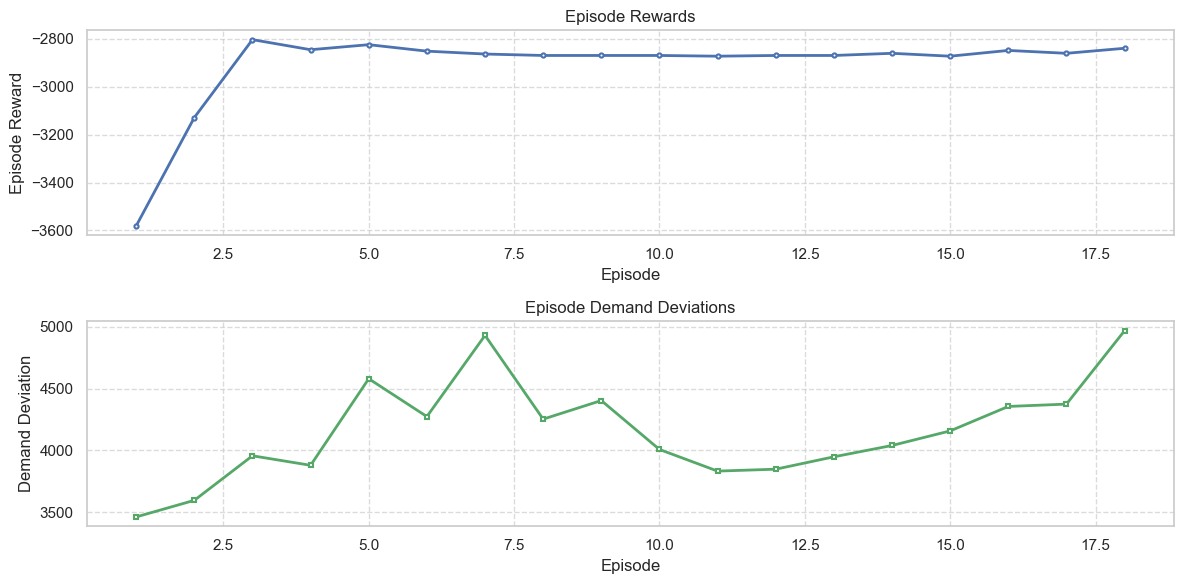

In [27]:
plot_rewards_and_deviations(rewards, deviations, 'rewards_and_deviations_during_train')

In [28]:
evaluate_saved_models(model_save_dir, num_train_episodes, num_test_episodes, 10)

ValueError: Shape of passed values is (208, 4), indices imply (208, 3)

In [ ]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

def plot_rewards_and_deviations_3d(episode_rewards, demand_deviations, saving_name, model_save_dir=model_save_dir):

    episodes = np.arange(1, len(episode_rewards) + 1)
    z = np.zeros_like(episodes)

    fig = plt.figure(figsize=(12, 6))

    ax1 = fig.add_subplot(121, projection='3d')
    ax1.plot(episodes, z, episode_rewards, linewidth=2, color='b', marker='o', markersize=6, markerfacecolor='w', markeredgewidth=1.5)
    ax1.set_xlabel("Episode")
    ax1.set_ylabel("Z-axis")
    ax1.set_zlabel("Episode Reward")
    ax1.set_title("3D Episode Rewards")

    ax2 = fig.add_subplot(122, projection='3d')
    ax2.plot(episodes, z, demand_deviations, linewidth=2, color='r', marker='s', markersize=6, markerfacecolor='w', markeredgewidth=1.5)
    ax2.set_xlabel("Episode")
    ax2.set_ylabel("Z-axis")
    ax2.set_zlabel("Demand Deviation")
    ax2.set_title("3D Episode Demand Deviations")

    plt.tight_layout()

    # Save the plot as a file
    plot_path = os.path.join(model_save_dir, saving_name + '.png')
    plt.savefig(plot_path)

    # Show the plot
    plt.show()

In [ ]:
plot_rewards_and_deviations_3d(rewards[:], deviations[:], '3D_rewards_and_deviations_during_train')

In [ ]:
def plot_rewards_and_deviations_barchart(episode_rewards, demand_deviations, saving_name, model_save_dir=model_save_dir):
    episodes = range(1, len(episode_rewards) + 1)

    fig, ax = plt.subplots(figsize=(12, 6))
    
    bar_width = 0.35
    opacity = 0.7

    rewards_bars = ax.bar([episode - bar_width/2 for episode in episodes], episode_rewards, bar_width, alpha=opacity, color='b', label='Episode Rewards')
    deviation_bars = ax.bar([episode + bar_width/2 for episode in episodes], demand_deviations, bar_width, alpha=opacity, color='r', label='Demand Deviations')

    ax.set_xlabel('Episode')
    ax.set_ylabel('Values')
    ax.set_title('Episode Rewards and Demand Deviations')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()

    # Save the plot as a file
    plot_path = os.path.join(model_save_dir, 'BC'+ saving_name + '.png')
    plt.savefig(plot_path)

    # Show the plot
    plt.show()


In [ ]:
plot_rewards_and_deviations_barchart(rewards[:], deviations[:], '3D_rewards_and_deviations_during_train')